# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('C:/Users/vineetp/Desktop/ml_ai/gitrepo/gesture_final/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/vineetp/Desktop/ml_ai/gitrepo/gesture_final/Project_data/Project_data/val.csv').readlines())
batch_size = 39

In [4]:
def image_specifications(nb_frames, x, y):
    return [np.round(np.linspace(0, 29, nb_frames)).astype('int'), x, y]


img_specs = image_specifications(20, 100, 100)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def get_batch_labels_and_data(source_path, t, batch, batch_size, img_specs):
    x, y, z = len(img_specs[0]), img_specs[1], img_specs[2]
    img_idx = img_specs[0]  # create a list of image numbers you want to use for a particular video
    batch_data = np.zeros((batch_size, x, y, z, 3))  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size, 5))  # batch_labels is the one hot representation of the output
    
    for folder in range(batch_size):  # iterate over the batch_size
        imgs = os.listdir('{0}/{1}'.format(source_path, t[folder + (batch * batch_size)].split(';')[0]))  # read all the images in the folder
        
        for idx, item in enumerate(img_idx):  # Iterate iver the frames/images of a folder to read them in
            image = imread('{0}/{1}/{2}'.format(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])).astype(np.float32)
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            
            if image.shape[0] != image.shape[1]:
                image = image[:120, 20:140]
            image = resize(image, (y, z))
            
            batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255.0  # normalise and feed in the image
            batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255.0  # normalise and feed in the image
            batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255.0  # normalise and feed in the image
        
        batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
    
    return batch_data, batch_labels


def generator(source_path, folder_list, batch_size, img_specs=img_specs):
    print(f"Source Path: {source_path}; Batch Size: {batch_size}")
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list) / batch_size)
        for batch in range(num_batches):  # we iterate over the number of batches
            yield get_batch_labels_and_data(source_path, t, batch, batch_size, img_specs)  # you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list) % batch_size != 0:
            batch_size = len(folder_list) % batch_size
            yield get_batch_labels_and_data(source_path, t, batch, batch_size, img_specs)  # you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/vineetp/Desktop/ml_ai/gitrepo/gesture_final/Project_data/Project_data/train'
val_path = 'C:/Users/vineetp/Desktop/ml_ai/gitrepo/gesture_final/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print(f"# training sequences: {num_train_sequences}")
num_val_sequences = len(val_doc)
print(f"# validation sequences: {num_val_sequences}")
num_epochs = 20 # choose the number of epochs
print(f"# epcohs: {num_epochs}")

# training sequences: 663
# validation sequences: 100
# epcohs: 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling3D
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling3D, MaxPooling2D
from tensorflow.keras.layers import TimeDistributed

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras import optimizers

In [8]:
input_shape = (len(img_specs[0]), img_specs[1], img_specs[2], 3)

### Model - 1:

In [9]:
# write your model here

# model 1 -- base model

# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))

# model.add(Conv3D(63, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 20 <br />
Train accuracy: 0.20 and Validation accuracy: 0.41 <br />
The model is unable to learn, adding more layers to the model

### Model - 2

In [10]:
# model 2 -- increasing the number of layers

# model = Sequential()

# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(32, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(64, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(128, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(63, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(5, activation='softmax'))

Number of Epochs: 20<br />
Train accuracy: 0.61 and Validation accuracy: 0.75 <br />
The train accuracy and the validation accuracy are sub-par, reducing some of the parameters.

### Model - 3

In [11]:
# model 3 -- reducing the number of parameters

# model = Sequential()

# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
# model.add(Flatten())
# model.add(Dense(64,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(5, activation='softmax'))

Number of Epcohs: 20 <br />
Train accuracuy: 0.97 and Validation accuracy: 0.83 <br />
Model seems to be overfitting, reducing the number of parameters even further.

### Model - 4

In [12]:
# model 4 -- reducing even more trainable parameters

# model = Sequential()

# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(5, activation='softmax'))

Number of Epochs: 20 <br />
Train accuracuy: 0.17 and Validation accuracy: 0.5 <br />
Reducing the number of parameters too much has lead a model thats significanlty underfitting. <br />
Increasing the number of epochs from 20 to 40 and creating a new model as well as removing the Dropout layers.

### Model - 5

In [13]:
# model - 5 -- Increasing the number of parameters

# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 40<br />
Training accuracy: 1.00 and Validation accuracy: 0.91 <br />
Model is clearly overfitting. Reducing the number of parameters and adding Dropout layers again.

### Model - 6

In [14]:
# model - 6 -- Reducing number of parameters and re-introducing dropout layers

# model = Sequential()

# model.add(Conv3D(16, (5, 5, 5), activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D((2, 2, 2), padding='same'))
# model.add(BatchNormalization())

# model.add(Conv3D(32, (3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# model.add(BatchNormalization())

# model.add(Conv3D(64, (3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(5, activation='softmax'))

Number of Epochs: 40 <br />
Training accuracy: 0.99 and Validation accuracy: 1.00 <br />
Model still seems to overfit on the data, even though the validation accuracy has increased significantly. <br />
Increasing the number of Dropout layers, and using GlobalAveragePooling3D instead of Flatten.

### Model - 7

In [15]:
# model - 7 -- Increasing the number of Droupout layers and replaing Flatten with GlobalAveragePooling3D

# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GlobalAveragePooling3D())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 40<br />
Train accuracy: 0.99 and Validation accuracy: 0.91 <br />
Both the train and validation accuracy are in 0.9 range. <br />
However with how close the train accuracy is to 1, trying different architectures as it's highly likely that the model is overfitting.

### Model - 8

In [16]:
# model - 8 -- CNN with LSTM, reducing the number of epochs to 20

# model = Sequential()

# model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(64))
# model.add(Dropout(0.25))
        
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.25))
        
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 20 <br />
Train accuracy: 0.50 and Validation accuracy: 0.66 <br />
The accuracy of the model is sub-par. Trying a different architecture -> Conv2D with GRU

### Model - 9

In [17]:
# model - 9 -- TimeDistributed Conv2D + GRU

# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(63, activation='relu')))
# model.add(BatchNormalization())

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='relu'))

Number of Epochs: 40 <br />
Train accuracy: 0.96 and Validation accuracy: 0.81 <br />
The difference between the train and validation accuracy is significant, adding Dropout layers to the model.

### Model - 10

In [18]:
# model - 10 -- TimeDistributed Conv2D + GRU

# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(63, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='relu'))

Number of Epochs: 40 <br />
Train accuracy: 0.86 and Validation accuracy: 0.58 <br />
Changing the model to TimeDistributed Conv2D with GlobalAveragePooling3D, increasing the number of epochs to 50.

### Model - 11

In [19]:
# model - 11 -- TimeDistributed Conv2D with GlobalAvreagePooling3D

# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(GlobalAveragePooling3D())
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

Epochs: 50 <br />
Train accuracy: 0.99 and Validation accuracy: 0.91 <br />
Both the train and validation accuracy are in the .9 range <br />
However with how close the Train accuracy is close to 1 the model is likely overfitting. <br />
Introducing Dropout layers to Model - 10, keeping the number of epochs same.

### Model - 12 - Final Model

In [20]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D(2, 2)))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Number of Epochs: 50 <br />
Train accuracy: 0.93 and Validation Accuracy = 0.91 <br />
Both the train and validation accuracy are in the range of .9 <br />
As well as the difference in the accuracies for the train and validation set is not too significant. <br />
Selecting __Model - 12__ (TimeDistributed Conv2D with GlobalAveragePooling3D and Dropouts).

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [21]:
optimiser = optimizers.Adam(lr=0.01)  # write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 98, 98, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 49, 49, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 20, 49, 49, 32)   128       
 ormalization)                                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 47, 47, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 23, 23, 64)   0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
model_name = 'model_init_{}/'.format(str(curr_dt_time).replace(' ', '').replace(':', '_'))
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)  # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [25]:
num_epochs =50
print(f"Epochs: {num_epochs}")

Epochs: 50


In [26]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source Path: C:/Users/vineetp/Desktop/ml_ai/gitrepo/gesture_final/Project_data/Project_data/train; Batch Size: 39


C:\Users\vineetp\AppData\Local\Temp\ipykernel_39272\1471780817.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread('{0}/{1}/{2}'.format(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])).astype(np.float32)


Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.7887 - categorical_accuracy: 0.4208 Source Path: C:/Users/vineetp/Desktop/ml_ai/gitrepo/gesture_final/Project_data/Project_data/val; Batch Size: 39

Epoch 1: saving model to model_init_2023-08-1700_03_46.803863\model-00001-1.78868-0.42081-1.61148-0.21000.h5
17/17 [==============================] - 265s 16s/step - loss: 1.7887 - categorical_accuracy: 0.4208 - val_loss: 1.6115 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.3277 - categorical_accuracy: 0.5415 
Epoch 2: saving model to model_init_2023-08-1700_03_46.803863\model-00002-1.32769-0.54148-1.59390-0.28788.h5
17/17 [==============================] - 262s 16s/step - loss: 1.3277 - categorical_accuracy: 0.5415 - val_loss: 1.5939 - val_categorical_accuracy: 0.2879 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.2125 - categorical_accuracy: 0.5611 
Epoch 3: savi

Epoch 22/50
17/17 [==============================] - ETA: 0s - loss: 0.3457 - categorical_accuracy: 0.8718 
Epoch 22: saving model to model_init_2023-08-1700_03_46.803863\model-00022-0.34566-0.87179-2.04799-0.50000.h5
17/17 [==============================] - 256s 15s/step - loss: 0.3457 - categorical_accuracy: 0.8718 - val_loss: 2.0480 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 23/50
17/17 [==============================] - ETA: 0s - loss: 0.3395 - categorical_accuracy: 0.8884 
Epoch 23: saving model to model_init_2023-08-1700_03_46.803863\model-00023-0.33945-0.88839-0.83922-0.75000.h5
17/17 [==============================] - 251s 15s/step - loss: 0.3395 - categorical_accuracy: 0.8884 - val_loss: 0.8392 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 24/50
17/17 [==============================] - ETA: 0s - loss: 0.3265 - categorical_accuracy: 0.8763 
Epoch 24: saving model to model_init_2023-08-1700_03_46.803863\model-00024-0.32647-0.87632-1.88269-0.58333.h5
17/17 [===

17/17 [==============================] - ETA: 0s - loss: 0.1217 - categorical_accuracy: 0.9563 
Epoch 43: saving model to model_init_2023-08-1700_03_46.803863\model-00043-0.12165-0.95626-1.41102-0.41667.h5
17/17 [==============================] - 252s 15s/step - loss: 0.1217 - categorical_accuracy: 0.9563 - val_loss: 1.4110 - val_categorical_accuracy: 0.4167 - lr: 0.0010
Epoch 44/50
17/17 [==============================] - ETA: 0s - loss: 0.1849 - categorical_accuracy: 0.9291 
Epoch 44: saving model to model_init_2023-08-1700_03_46.803863\model-00044-0.18493-0.92911-1.57179-0.50000.h5
17/17 [==============================] - 248s 15s/step - loss: 0.1849 - categorical_accuracy: 0.9291 - val_loss: 1.5718 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 45/50
17/17 [==============================] - ETA: 0s - loss: 0.1927 - categorical_accuracy: 0.9261 
Epoch 45: saving model to model_init_2023-08-1700_03_46.803863\model-00045-0.19273-0.92609-1.86577-0.58333.h5
17/17 [===============

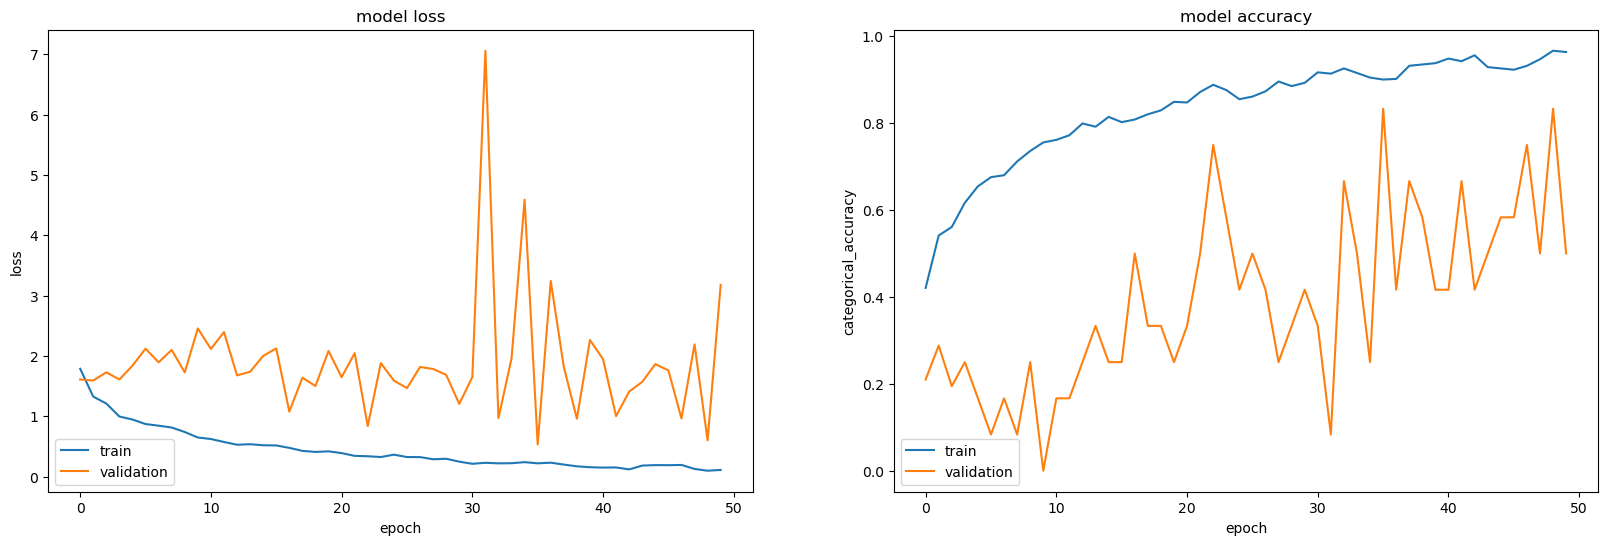

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')